<a href="https://colab.research.google.com/github/shunnyK/AI/blob/main/week09_TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train shapes: (2304, 60, 4) (2304,)
Test shapes : (532, 60, 4) (532,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0227 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0016 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0013 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0012 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0012
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0012 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0012 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0010 - val_loss: 0.0022 - learning_rate: 

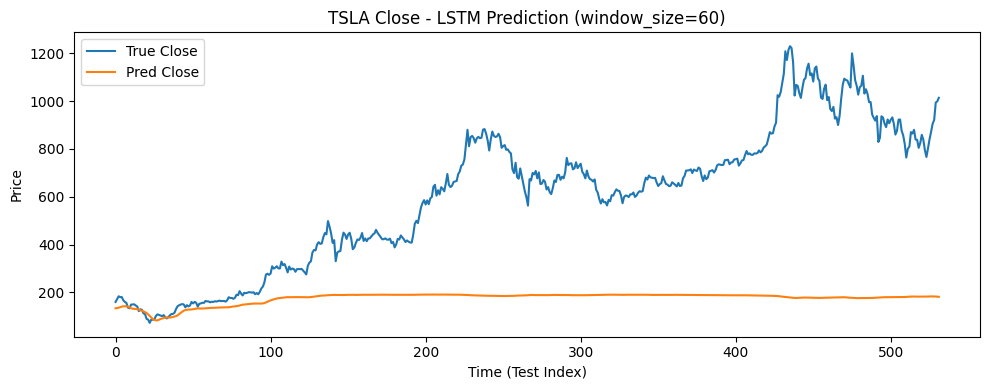

In [ ]:
# ==========================================
# LSTM으로 TSLA 종가 예측 (window_size 사용)
# - 입력: Open, High, Low, Close
# - 타깃: 다음 시점 Close
# - 시퀀스 길이: window_size (예: 60)
# ==========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


FILE_PATH = "/content/drive/MyDrive/TSLA.csv"

# 1) 데이터 로드 & 열 정리
df = pd.read_csv(FILE_PATH)
df = df.drop(columns=["Date", "Adj Close", "Volume"], errors="ignore")
df = df.dropna().reset_index(drop=True)

# 사용 피처: Open, High, Low, Close
want = ["open", "high", "low", "close"]
feature_cols = [c for c in df.columns if c.lower() in want]


# 컬럼 순서 정렬
ordered = []
for c in ["Open", "High", "Low", "Close"]:
    if c in df.columns:
        ordered.append(c)
if ordered:
    feature_cols = ordered

assert "Close" in feature_cols, "CSV에 'Close' 열이 필요합니다."

data = df[feature_cols].astype("float32").copy()
n_features = len(feature_cols)
target_col = "Close"
target_index = feature_cols.index(target_col)

# 2) 시간 순서 유지한 Train/Test 분할
train_ratio = 0.8
n_total = len(data)
n_train = int(n_total * train_ratio)

train_df = data.iloc[:n_train].copy()
test_df  = data.iloc[n_train:].copy()

# 3) 스케일링 (Train으로만 학습)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.values)
test_scaled  = scaler.transform(test_df.values)

# 4) 시퀀스 생성 (window_size 사용)
def make_sequences(arr, window_size, target_idx):
    """
    arr: (N, F) 스케일된 배열
    window_size: 과거 몇 시점 사용할지
    target_idx: 타깃 열 인덱스 (Close)
    반환: X (N-window, window, F), y (N-window,)
    """
    X, y = [], []
    for i in range(window_size, len(arr)):
        X.append(arr[i-window_size:i, :])
        y.append(arr[i, target_idx])
    return np.array(X), np.array(y)

window_size = 60  # ← 여기만 바꿔서 실험해보면 됨
X_train, y_train = make_sequences(train_scaled, window_size, target_index)
X_test,  y_test  = make_sequences(test_scaled,  window_size, target_index)

print("Train shapes:", X_train.shape, y_train.shape)  # (samples, window_size, features)
print("Test shapes :", X_test.shape,  y_test.shape)

# 5) 모델 정의 (간단한 2층 LSTM)
tf.random.set_seed(42)
model = models.Sequential([
    layers.Input(shape=(window_size, n_features)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(1)  # 스케일된 Close 1개 예측
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# 6) 학습 (EarlyStopping 권장)
es  = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=1
)

# 7) 예측 & 역스케일링(오직 Close만 복원)
def inverse_close(scaled_close_vec, fitted_scaler, target_idx, n_feat):
    """
    MinMaxScaler는 다변량 기준으로 학습됐기 때문에,
    Close만 복원할 때 0으로 채운 임시 배열을 만든 뒤 inverse_transform을 사용.
    """
    temp = np.zeros((len(scaled_close_vec), n_feat))
    temp[:, target_idx] = scaled_close_vec.reshape(-1)
    inv = fitted_scaler.inverse_transform(temp)
    return inv[:, target_idx]

y_pred_scaled = model.predict(X_test, verbose=0).reshape(-1)
y_true = inverse_close(y_test, scaler, target_index, n_features)
y_pred = inverse_close(y_pred_scaled, scaler, target_index, n_features)

rmse = sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"\nTest RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# 8) 시각화 (한 플롯)
plt.figure(figsize=(10,4))
plt.plot(y_true, label="True Close")
plt.plot(y_pred, label="Pred Close")
plt.title(f"TSLA Close - LSTM Prediction (window_size={window_size})")
plt.xlabel("Time (Test Index)")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()